In [1]:
library(igraph)
library(ggnetwork)
library(tidyverse)
library(cowplot)

theme_transparent <- theme(panel.background = element_rect(fill = "transparent"), # bg of the panel
                           plot.background = element_rect(fill = "transparent", color = NA), # bg of the plot
                           panel.grid.major = element_blank(), # get rid of major grid
                           panel.grid.minor = element_blank(), # get rid of minor grid
                           legend.background = element_rect(fill = "transparent", color = NA), # get rid of legend bg
                           legend.box.background = element_rect(fill = "transparent", color = NA), # get rid of legend panel bg
                           strip.background = element_rect(fill="transparent", color = NA)
)

rslt <- '../results/'


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
✔ purrr   0.3.3     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ dplyr::groups()        masks igraph::groups()
✖ dplyr::lag()           masks stats::lag()
✖ purrr::simplify()      masks igraph::simplify()


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default 

# Mappings

In [2]:
path <- '~/projects/waffles/results/fuma_mapping/'

maps <- bind_rows(read_tsv(paste0(path, 'physical_mapping.tsv'), col_types = 'cccc') %>% mutate(map = 'Physical'),
                  read_tsv(paste0(path, 'chromatin_interaction_mapping.tsv'), col_types = 'cccc') %>% mutate(map = 'Chromatin'),
                  read_tsv(paste0(path, 'eqtl_mapping.tsv'), col_types = 'ccc') %>% mutate(map = 'eQTL')) %>%
    mutate(map = factor(map, levels = c('Physical', 'Chromatin', 'eQTL')))

In [3]:
select(maps, map, rsID, ensg) %>% unique %>% .$map %>% table

.
 Physical Chromatin      eQTL 
   174879   2394589    411120 

In [4]:
# library(ggupset)

# select(maps, map, rsID, ensg) %>% 
#     unique %>%
#     group_by(rsID, ensg) %>%
#     summarize(kk = paste(map, collapse = '-')) 
# %>%
#     ggplot(aes(x = map)) +
#         geom_bar() +
#         scale_x_upset()

Warning message:
“Removed 7919 rows containing non-finite values (stat_boxplot).”


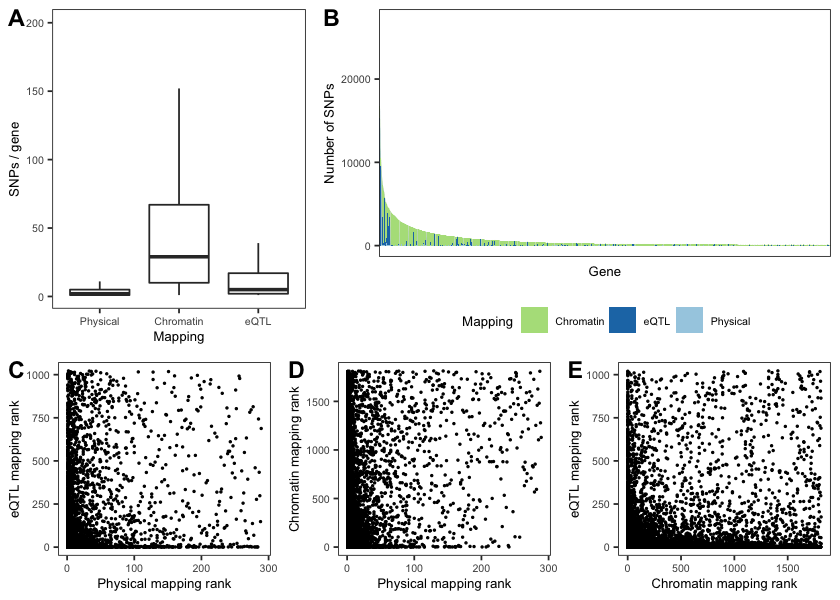

In [5]:
snpsXgene_plt <- group_by(maps, ensg, map) %>%
    summarize(n = n()) %>%
    ggplot(aes(x = map, y = n)) +
        geom_boxplot(outlier.colour = NA) +
        labs(y = 'SNPs / gene', x = 'Mapping') +
        theme_bw() +
        scale_y_continuous(limits = c(NA, 200)) +
        theme(text = element_text(size = 8)) +
        theme_transparent

most_described <- group_by(maps, ensg, map) %>%
    summarize(n = n()) %>%
    arrange(desc(n)) %>%
    ungroup %>%
    spread(map, n) %>%
    replace(is.na(.), 0) %>%
    mutate(n = Physical + eQTL + Chromatin) %>%
    arrange(desc(n)) %>%
    mutate(ensg = factor(ensg, levels = unique(ensg))) %>%
    filter(n > 100) %>%
    gather('map','counts',-ensg,-n) %>%
    ggplot(aes(x = ensg, y = counts, fill = map)) +
        geom_bar(stat = 'identity') +
        theme_bw() +
        labs(x = 'Gene', y = 'Number of SNPs', fill = 'Mapping') +
        scale_fill_manual(values = c('Physical' = '#a6cee3',
                                     'eQTL' = '#1f78b4',
                                     'Chromatin' = '#b2df8a')) +
        theme(axis.text.x = element_blank(),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              legend.position = 'bottom',
              text = element_text(size = 8),
              axis.ticks.x = element_blank()) +
        theme_transparent

rank_maps <- group_by(maps, ensg, map) %>%
    summarize(n = n()) %>%
    arrange(desc(n)) %>%
    ungroup %>%
    spread(map, n) %>%
    replace(is.na(.), 0) %>%
    mutate(Physical_rnk = dense_rank(Physical),
           eQTL_rnk = dense_rank(eQTL),
           Chromatin_rnk = dense_rank(Chromatin))

phy_vs_eqtl <- ggplot(rank_maps, aes(Physical_rnk, eQTL_rnk)) +
    geom_point(size = .3) +
    theme_bw() +
    labs(x = 'Physical mapping rank', y = 'eQTL mapping rank') +
    theme(text = element_text(size = 8)) +
    theme_transparent

phy_vs_chr <- ggplot(rank_maps, aes(Physical_rnk, Chromatin_rnk)) +
    geom_point(size = .3) +
    theme_bw() +
    labs(x = 'Physical mapping rank', y = 'Chromatin mapping rank') +
    theme(text = element_text(size = 8)) +
    theme_transparent

chr_vs_eqtl <- ggplot(rank_maps, aes(Chromatin_rnk, eQTL_rnk)) +
    geom_point(size = .3) +
    theme_bw() +
    labs(x = 'Chromatin mapping rank', y = 'eQTL mapping rank') +
    theme(text = element_text(size = 8)) +
    theme_transparent

options(repr.plot.width=7, repr.plot.height=5)
plot_grid(plot_grid(snpsXgene_plt, most_described, rel_widths = c(.6, 1), labels = c('A', 'B')),
          plot_grid(phy_vs_eqtl, phy_vs_chr, chr_vs_eqtl, ncol = 3, labels = c('C','D','E')),
          nrow = 2, rel_heights = c(1,.7))
ggsave(filename = 'fig/mappings_per_gene.pdf', width=7, height=5, bg = "transparent")
ggsave(filename = 'fig/mappings_per_gene.png', width=7, height=5, bg = "transparent")

Warning message:
“Removed 1 rows containing missing values (geom_text).”
Warning message:
“Removed 1 rows containing missing values (geom_text).”


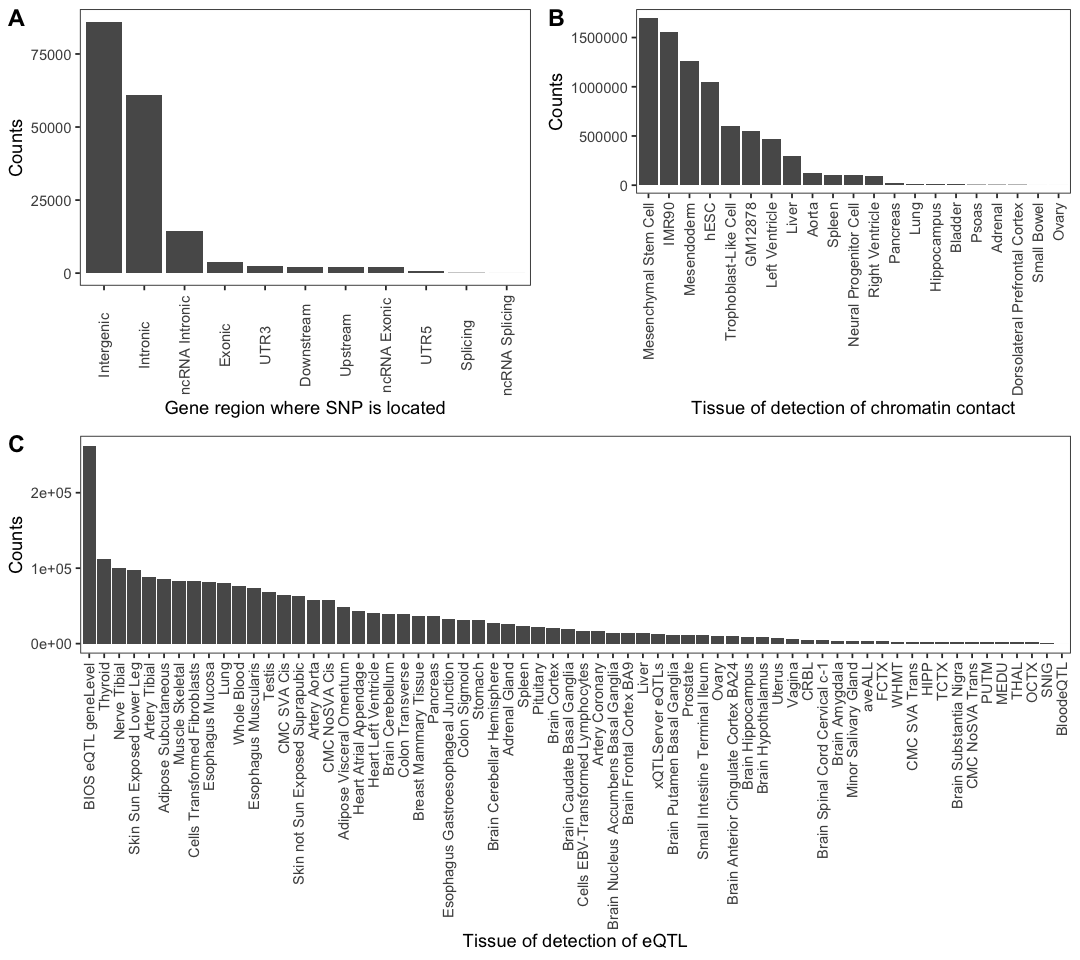

In [6]:
physicalRegion_plt <- filter(maps, map == 'Physical') %>%
    group_by(annot) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(annot = gsub('_', ' ', annot),
           annot = tools::toTitleCase(annot),
           annot = factor(annot, levels = unique(annot))) %>%
    ggplot(aes(x = annot, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Gene region where SNP is located', y = 'Counts') +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = .5)) +
        theme_transparent

eqtlTissue_plt <- filter(maps, map == 'eQTL') %>%
    group_by(tissue) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(tissue = gsub('_', ' ', tissue),
           tissue = tools::toTitleCase(tissue),
           tissue = factor(tissue, levels = unique(tissue))) %>%
    ggplot(aes(x = tissue, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Tissue of detection of eQTL', y = 'Counts') +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1)) +
        theme_transparent

chrTissue_plt <- filter(maps, map == 'Chromatin') %>%
    group_by(tissue) %>%
    summarize(n = n()) %>%
    arrange(-n) %>%
    ungroup %>%
    mutate(tissue = gsub('_', ' ', tissue),
           tissue = tools::toTitleCase(tissue),
           tissue = factor(tissue, levels = unique(tissue))) %>%
    ggplot(aes(x = tissue, y = n)) +
        geom_bar(stat = 'identity') +
        labs(x = 'Tissue of detection of chromatin contact', y = 'Counts') +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = .5, hjust = 1)) +
        theme_transparent

options(repr.plot.width=9, repr.plot.height=8)
plot_grid(plot_grid(physicalRegion_plt, chrTissue_plt, labels = c('A','B')), 
          eqtlTissue_plt, 
          labels = c(NA,'C'), nrow = 2, rel_heights = c(.8, 1))
ggsave(filename = 'fig/tissue_origin.pdf', 
       width=9, height=8, bg = "transparent")

# Network stats

In [7]:
snp_stats <- function(path) {
    g <- read_csv(paste0(rslt, path), col_types = 'ccdccc') %>%
        select(SNP_1, SNP_2) %>%
        unique %>%
        graph_from_data_frame(directed = FALSE) %>%
        simplify
    
    c(nodes = length(V(g)),
      edges = length(E(g)),
      avg_degree = mean(degree(g)),
      components = components(g)$no,
      largest_component = max(components(g)$csize))
}

snp_stats <- bind_cols(Standard = snp_stats('noFilter/sign_SNPPairs.txt'),
                       Physical = c(0, 0, NA, NA, NA),
                       Chromatin = snp_stats('withBiofilter_filter/chromatin/sign_SNPPairs.txt'),
                       eQTL = snp_stats('withBiofilter_filter/eqtl/sign_SNPPairs.txt'))
rownames(snp_stats) <- c('Nodes', 'Edges', 'Avg degree','Components', 'Largest component')
snp_stats

Warning message:
“Setting row names on a tibble is deprecated.”


,Standard,Physical,Chromatin,eQTL
,<dbl>,<dbl>,<dbl>,<dbl>
Nodes,55.000000,0,20.0,46.000000
Edges,57.000000,0,19.0,64.000000
Avg degree,2.072727,NA,1.9,2.782609
Components,12.000000,NA,5.0,6.000000
Largest component,25.000000,NA,11.0,17.000000


In [8]:
gene_stats <- function(path) {
    g <- read_csv(paste0(rslt, path), col_types = 'cdccd') %>%
        separate(genePairs_names, into = c('gene_a', 'gene_b'), sep = ' ') %>%
        select(gene_a, gene_b) %>%
        unique %>%
        graph_from_data_frame(directed = FALSE)
    
    c(nodes = length(V(g)),
      edges = length(E(g)),
      avg_degree = mean(degree(g)),
      components = components(g)$no,
      largest_component = max(components(g)$csize))
}

gene_stats <- bind_cols(Standard = gene_stats('noFilter/sign_GenePairs.txt'),
                        Physical = c(0, NA, NA, NA, NA),
                        Chromatin = gene_stats('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt'),
                        eQTL = gene_stats('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt'))
rownames(gene_stats) <- c('Nodes', 'Edges', 'Avg degree','Components', 'Largest component')
gene_stats

Warning message:
“Setting row names on a tibble is deprecated.”


,Standard,Physical,Chromatin,eQTL
,<dbl>,<dbl>,<dbl>,<dbl>
Nodes,29.000000,0,10,11.000000
Edges,26.000000,NA,5,7.000000
Avg degree,1.793103,NA,1,1.272727
Components,8.000000,NA,5,5.000000
Largest component,6.000000,NA,2,3.000000


# Figures

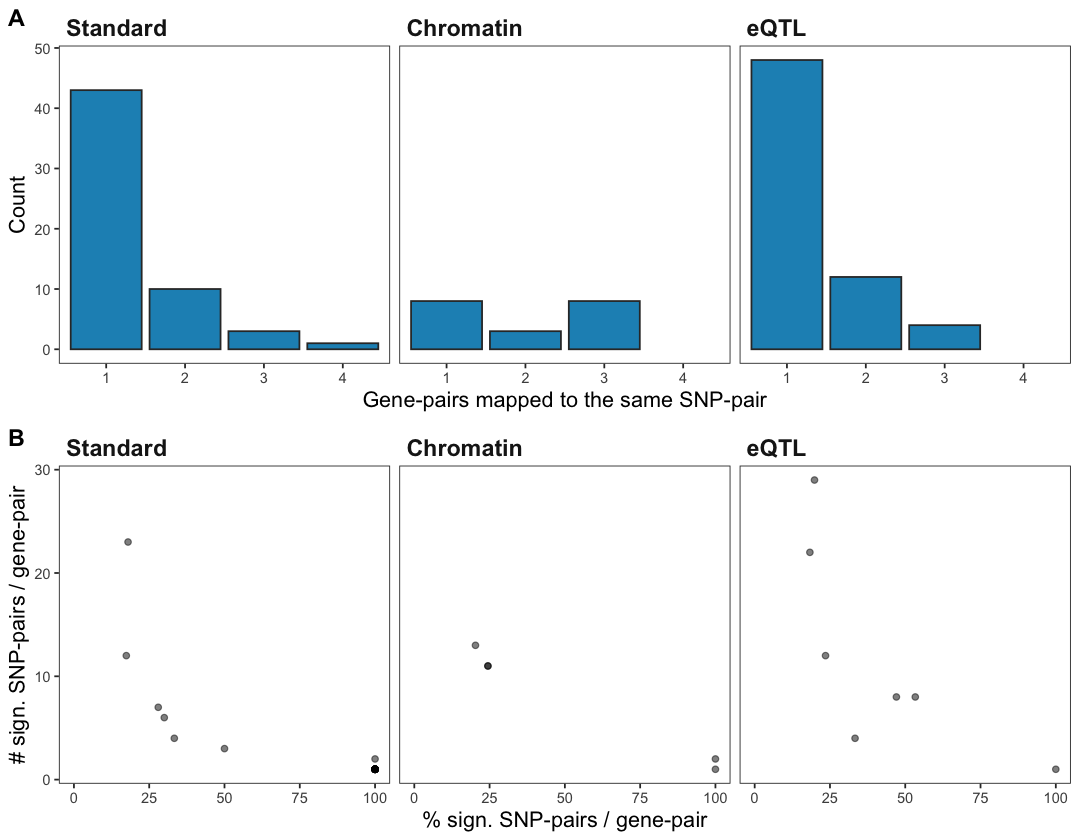

In [9]:
get_mapped_genes <- function(genes, snps) {

    uniq_snp2gene <- read_csv(paste0(rslt, genes), col_types = 'cdccd') %>%
        separate_rows(SNP1, sep = ' ') %>%
        separate_rows(SNP2, sep = ' ') %>%
        separate(genePairs_names, sep = ' ', into = c('gene1','gene2')) %>%
        mutate(uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               uniq_snp_id = cbind(SNP1, SNP2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               gene_pair = TRUE) %>%
        select(uniq_gene_id, uniq_snp_id, gene_pair) %>%
        unique

    uniq_snp <- read_csv(paste0(rslt, snps), col_types = 'ccdccc') %>%
        mutate(uniq_snp_id = cbind(SNP_1, SNP_2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               uniq_gene_id = cbind(gene1, gene2) %>% apply(1, sort) %>% apply(2, paste, collapse = '_'),
               snp_pair = TRUE) %>%
        select(uniq_gene_id, uniq_snp_id, snp_pair) %>%
        unique
    
    full_join(uniq_snp, uniq_snp2gene, by = c("uniq_gene_id", "uniq_snp_id")) %>%
        mutate(gene_pair = ifelse(is.na(gene_pair), FALSE, TRUE),
               snp_pair = ifelse(is.na(snp_pair), FALSE, TRUE))
    
}

maps <- bind_rows(get_mapped_genes('noFilter/sign_GenePairs.txt', 'noFilter/sign_SNPPairs.txt') %>% mutate(exp = 'Standard'),
                  get_mapped_genes('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt',
                                   'withBiofilter_filter/chromatin/sign_SNPPairs.txt') %>% mutate(exp = 'Chromatin'),
                  get_mapped_genes('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt',
                                   'withBiofilter_filter/eqtl/sign_SNPPairs.txt') %>% mutate(exp = 'eQTL')) %>%
    select(uniq_gene_id, uniq_snp_id, gene_pair, snp_pair, exp) %>%
    mutate(exp = factor(exp, levels = c('Standard', 'Chromatin', 'eQTL')))

snp2gene_plt <- maps %>%
    filter(snp_pair) %>%
    group_by(uniq_snp_id, exp) %>%
    summarise(n = factor(as.character(n()), levels = as.character(seq(1, 9))),
              gene_pair = ifelse(any(gene_pair), 'Yes', 'No')) %>%
    ggplot(aes(x = n)) +
        geom_bar(stat = 'count', color = 'gray20', fill = '#1d91c0') +
        labs(x = 'Gene-pairs mapped to the same SNP-pair', y = 'Count', fill = 'Any significant gene-pair') +
        facet_grid(. ~ exp) +
        scale_fill_manual(values = c('Yes' = '#1d91c0', 'No' = 'gray80')) +
        theme_bw() +
        theme(strip.background = element_blank(),
              strip.text = element_text(size = 14, face = "bold", hjust=0),
              axis.title = element_text(size = 13),
              legend.position = 'bottom') +
        theme_transparent

gene2snp_plt <- maps %>%
    filter(gene_pair) %>%
    group_by(uniq_gene_id, exp) %>%
    summarise(snp_pairs = sum(snp_pair),
              pc_snp_pairs = 100 * snp_pairs / n()) %>%
    ggplot() +
        geom_point(aes(pc_snp_pairs, snp_pairs), alpha = 0.5) +
        labs(x = '% sign. SNP-pairs / gene-pair', 
             y = '# sign. SNP-pairs / gene-pair') +
        facet_grid(. ~ exp) +
        scale_x_continuous(limits = c(0, NA)) +
        theme_bw() +
        theme(strip.background = element_blank(),
              strip.text = element_text(size = 14, face = "bold", hjust=0),
              axis.title = element_text(size = 13),
              legend.position = 'bottom') +
        theme_transparent

options(repr.plot.width=9, repr.plot.height=7)
plot_grid(snp2gene_plt, gene2snp_plt, nrow = 2, labels = c('A', 'B'))
ggsave(filename = 'fig/sign_snps_per_gene_and_viceversa.pdf', 
       width=9, height=7, bg = "transparent")

Loading required package: sna

Loading required package: statnet.common


Attaching package: ‘statnet.common’


The following object is masked from ‘package:base’:

    order


Loading required package: network

network: Classes for Relational Data
Version 1.16.0 created on 2019-11-30.
copyright (c) 2005, Carter T. Butts, University of California-Irvine
                    Mark S. Handcock, University of California -- Los Angeles
                    David R. Hunter, Penn State University
                    Martina Morris, University of Washington
                    Skye Bender-deMoll, University of Washington
 For citation information, type citation("network").
 Type help("network-package") to get started.



Attaching package: ‘network’


The following objects are masked from ‘package:igraph’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex

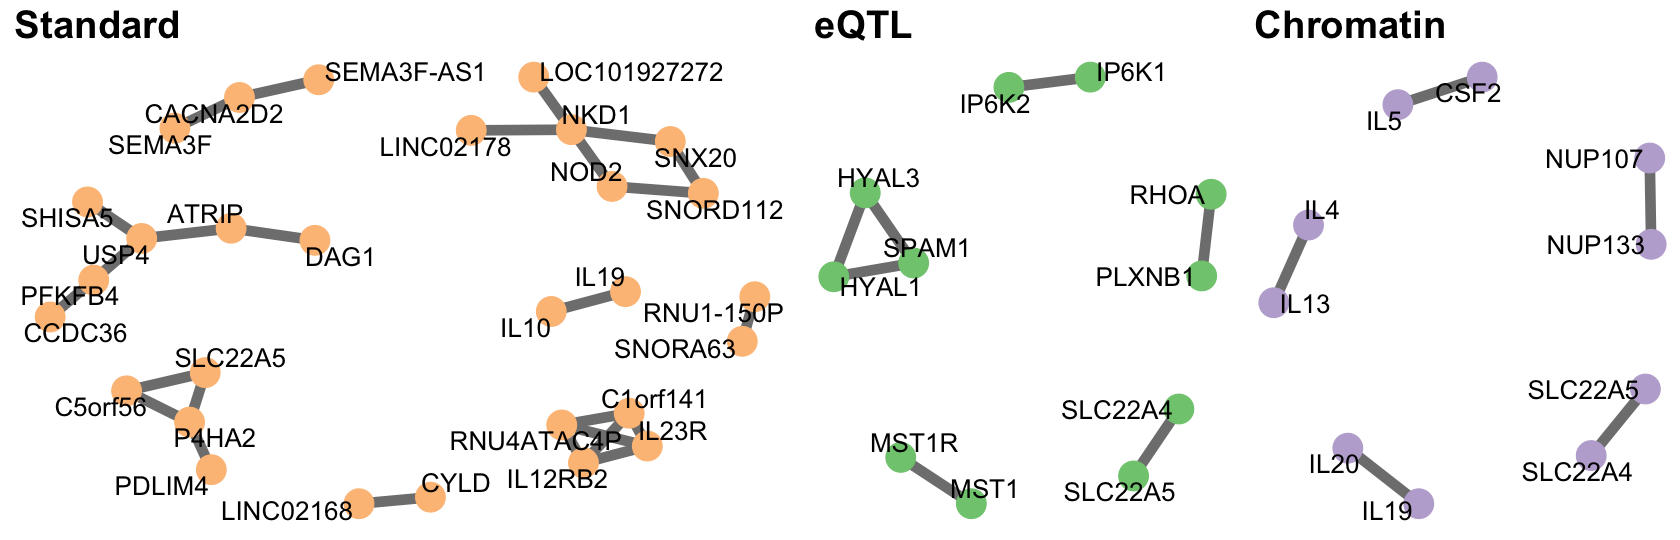

In [10]:
plot_genes <- function(path, tag, color) {

    read_csv(paste0(rslt, path), col_types = 'cdccd') %>%
    separate(genePairs_names, into = c('gene_a', 'gene_b'), sep = ' ') %>%
    select(gene_a, gene_b, MinP) %>%
    graph_from_data_frame(directed = FALSE) %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray50', size = 3) +
        geom_nodes(color = color, size = 8) +
        geom_nodetext_repel(aes(label = vertex.names), size = 5.5) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        ggtitle(tag) + 
        theme(plot.title = element_text(size = 23, face = "bold")) +
        theme_transparent
}

genes_eqtl <- plot_genes('withBiofilter_filter/eqtl/sign_GenePairs_withoutThreshold.txt', 'eQTL', '#7fc97f')
genes_chr <- plot_genes('withBiofilter_filter/chromatin/sign_GenePairs_withoutThreshold.txt', 'Chromatin', '#beaed4')
genes_noFilter <- plot_genes('noFilter/sign_GenePairs.txt', 'Standard', '#fdc086')

options(repr.plot.width=14, repr.plot.height=4.5)
plot_grid(genes_noFilter, genes_eqtl, genes_chr, ncol = 3, rel_widths = c(1, .55, .55))

ggsave(filename = 'fig/gene_networks.pdf', width=14, height=4.5, bg = "transparent")

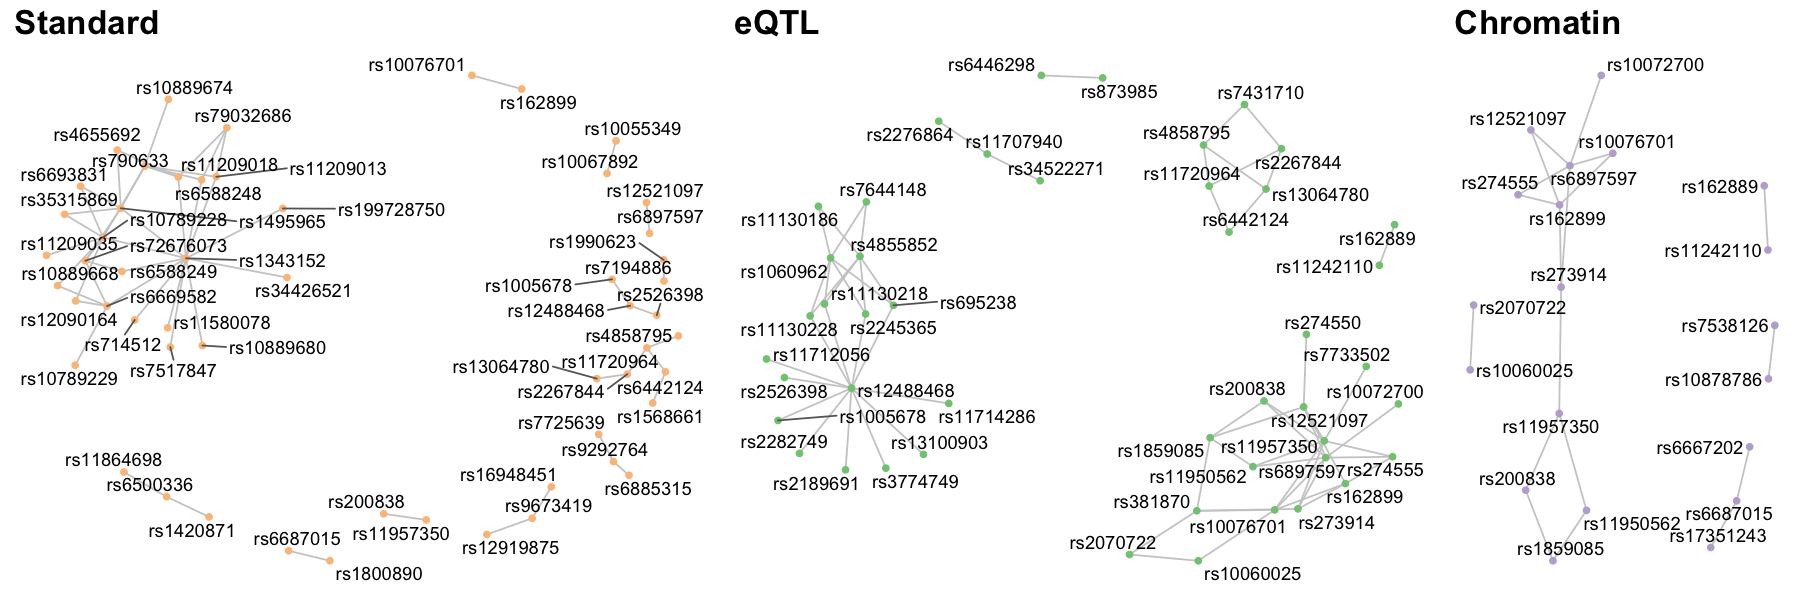

In [11]:
plot_genes <- function(path, tag, color) {

    read_csv(paste0(rslt, path), col_types = 'ccdccc') %>%
    select(SNP_1, SNP_2) %>%
    unique %>%
    graph_from_data_frame(directed = FALSE) %>%
    ggnetwork %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray80') +
        geom_nodes(color = color) +
        geom_nodetext_repel(aes(label = vertex.names)) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        ggtitle(tag) + 
        theme(plot.title = element_text(size = 20, face = "bold")) +
        theme_transparent

}

snp_eqtl <- plot_genes('withBiofilter_filter/eqtl/sign_SNPPairs.txt', 'eQTL', '#7fc97f')
snp_chr <- plot_genes('withBiofilter_filter/chromatin/sign_SNPPairs.txt', 'Chromatin', '#beaed4')
snp_noFilter <- plot_genes('noFilter/sign_SNPPairs.txt', 'Standard', '#fdc086')

options(repr.plot.width=15, repr.plot.height=5)
plot_grid(snp_noFilter, snp_eqtl, snp_chr, ncol = 3, rel_widths = c(1, 1, .5))

ggsave(filename = 'fig/snp_networks.pdf', width=15, height=5, bg = "transparent")